<b>Predicting  Students Exam Scores Across Different Subjects using KNN Regression</b> 

<b>Introduction:</b>
Our project deals with how different factors may affect how well a student performs on an exam in various subjects as well as the relationship between a student's scores across all the subjects tested (math, reading, and writing). We were curious to know if the students seemed to perform well/poorly in only a specific subject or all three. The question we will be trying to answer in our project is “Are students’ writing exam scores strongly correlated with their reading exam score? If so, could we accurately predict students’ writing exam score based on a student's reading exam score (%) using regression?” Since reading and writing are two subjects in which the content is very closely related, we wanted to know if the students' exam scores reflected this or if their scores were completely different. The data set that we will be using to help answer this question consists of marks secured by US highschool students in various subjects and is used to understand the effect of the parents education background, financial ability etc on students performances. 


<b>Methods & Results:</b>
Using the K-nearest neighbor regression model and linear regression model, we will be predicting what a student's writing score would be on an exam, based on their reading exam score. We have broken our code down into various steps in order for the viewer to better understand how we solved this problem. 

In [1]:
#Loading Packages
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(rvest)
library(cowplot)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ──────────────────────

Setting the Seed, Reading  and Cleaning the Data: 

The purpose of setting the seed is to make our data analysis reproducible.
Here, we read data directly from “URL” and provide “URL” to the function ‘read_csv’ as the path to the file. Since our project only deals with the students reading and writing score, we filtered for only those columns, leaving out the other ones in order for the data set to be easier to read.

In [58]:
set.seed(2000)
#Reading Data
url <- "http://roycekimmons.com/system/generate_data.php?dataset=exams&n=1000"
exam_data <- read_csv(url)
colnames(exam_data) <- c("gender", "race_ethnicity", "parental_level_of_education", "lunch", "test_preparation_course", "math_score", "reading_score", "writing_score")

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Splitting the data into testing and training sets: 

We split the data into a training and testing set. The training set is what we will use to create our model and the testing set is what we will use at the end of our finalized model to make our prediction. We chose 75% of our original data set to be the training set and the remaining 25% to be the testing set.

In [59]:
#Split
exam_split <- exam_data %>%
    initial_split(prop = 0.75, strata = writing_score)

In [60]:
#Assigning Training Data
exam_training <- exam_split %>%
  training()

In [61]:
#Assigning Testing Data
exam_testing <- exam_split %>%
  testing()

Analyzing the association between variables:

Using the ggpairs function allows us to produce a scatterplot from the selected variables  (writing_score vs. reading_score), along with a line graph of their distribution, and the correlation coefficient. The line graph shows that the data is  approximately normally distributed. Taking a look at the writing_score vs. math_score scatterplot, we can see that they are positively correlated with moderate strength (R-squared 0.661). Our other scatterplot, writing_score vs. reading_score shows us a positive correlation with high strength (R squared 0.910).  Since reading_score (x) explains more of the variation in writing_score (y)  than math_score can, we will be using it for our prediction models, KNN regression and simple linear regression. Based on all this information, we can conclude that using the variable "reading_score" to predict writing_score will result in a low RMSE, meaning a more accurate prediction of writing_score.


In [ ]:
exam_eda1 <- exam_training %>%
    select(writing_score, math_score) %>%
    ggpairs()
exam_eda1
exam_eda2 <- exam_training %>%
    select(writing_score, reading_score) %>%
    ggpairs()
exam_eda2

Applying K-NN Regression Model Specification:

Now that we have our optimal predictor, we will begin creating the KNN regression model. Setting the model  as “regression” lets our model know that we are dealing with the RMSPE for tuning and evaluation and makinga numerical prediction. We will set the ‘neighbors’ argument to equal the “tune” function since we don’t know the optimal K value to minimize RMSPE.

In [7]:
#KNN Regression Model Specificiation
exam_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

Creating recipe with standardization:

Because K-nearest neighbor models are largely influenced by the scale of the predictors, we apply step_scale
and step_center to all of the predictor variables so that each of them have a mean of 0 and standard deviation of 1 to standardize our data. Using the standardized data, a recipe is created for the preprocessing of our data using our variables of interest, reading_score and writing_score.

In [8]:
#Recipe with Standardization
exam_recipe <- recipe(writing_score ~ reading_score, data = exam_training) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

Cross Validation with 5 folds on training data:

We performed 5-fold  cross-validation to tune the KNN model and to help us choose the best k value. We set the 
strata argument to  writing_score to make sure the sampling proportion is equal for both the training and testing 
subsets. In cross validation, our training data is split into 5 chunks with same sizes, one of the chunks is used 
as validation set, and the other 4 chunks are combined to use as the training set. Cross-validation results in 
better estimate accuracy because our parameter choice now depends on multiple validation sets instead of only 1.

In [9]:
#Cross Validation with 5 folds on training data
exam_vfold <- exam_training %>%
  vfold_cv(v = 5, strata = writing_score)
set.seed(2000)

Creating workflow:

We create a workflow to chain the model and recipe together.

In [10]:
#Creating workflow
exam_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_spec)

Defining the tuning grid:

We ran cross-validation on a number of k values ranging from 1 to 200 in increments of 10.

In [11]:
#Setting grid parameters
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 10))

Collecting statistics from model:

The mean and standard error of the classifier's validation accuracy can be aggregated across folds by using the  collect_metrics function.

In [12]:
#Collecting statistics from model
exam_results <- exam_workflow %>%
  tune_grid(resamples = exam_vfold, grid = gridvals) %>%
  collect_metrics()
set.seed(2000)

Finding the minimum RMSE (mean value):

We use RMSE when predicting and evaluating prediction quality on the validation data. When the prediction is very close to the true value, the RMSPE value is small and  when the prediction is very far away from the true value, the RMSPE value is large, therefore we choose a K value that gives the minimum RMSPE value. The optimum K value is 31, which produces the smallest estimated RMSPE from cross-validation. 

In [13]:
#Finding the minimum RMSE (mean value)
exam_min <- exam_results %>%
  filter(.metric == "rmse") %>%
  arrange(mean) %>%
  slice(1)
exam_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,4.916215,5,0.1120453,Preprocessor1_Model04


In [14]:
#Assigning optimal K value to an object
k_min <- exam_min %>%
  pull(neighbors)

In [15]:
#Creating an object that only includes "rmse" in .metric (but with all data)
exam_results_cleanup <- exam_results %>%
  filter(.metric == "rmse")

Effect of the number of neighbors on the RMSPE:

According to the graph, the lowest RMSPE value, 4.916, occurs at K = 31. The RMSPE value is high when K value is between 0 and 10, the lowest RMSPE value occurs when K value is 23 to 33, then the RMSPE value increases as the value of K is larger. This is because when the K value is too small, our model is impacted too much by the training data. Due to its close adherence to training data, the model will not be able to predict new observations accurately, leading to large RMSPE values; this behavior is called overfitting. Oppositely, when the K value is too large,  our model is impacted too little by the training data since the prediction of new observation is just the average of the students’ writing score, also resulting in larger RMSPE; this behavior is called underfitting.


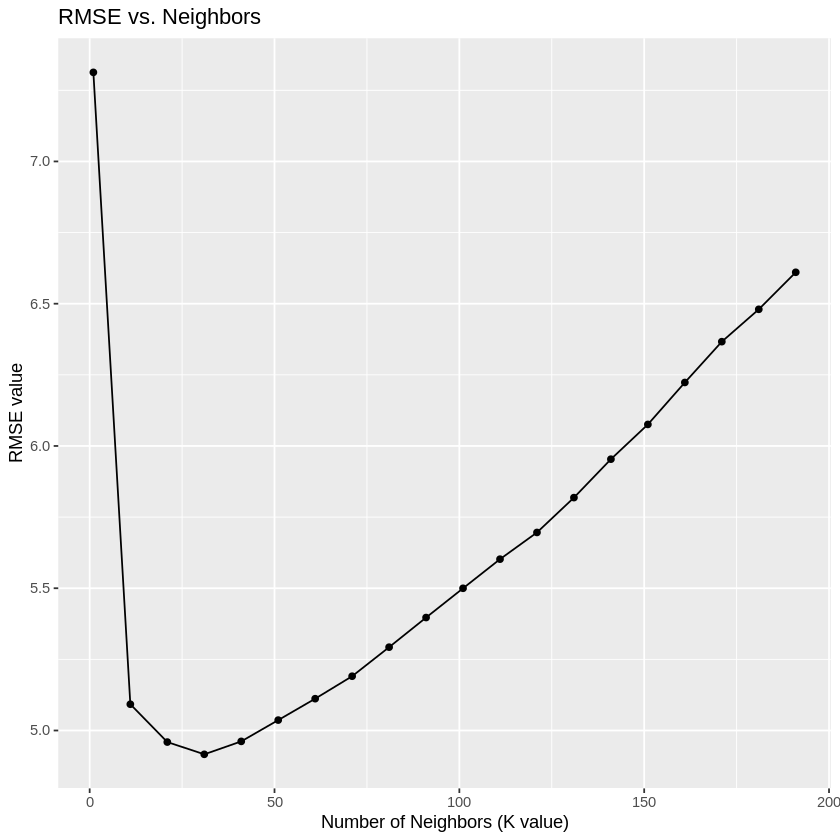

In [16]:
#Creating a plot with # of neighbors on x, rmse value on y.
rmse_plot <- exam_results_cleanup %>%
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (K value)", y = "RMSE value") +
  ggtitle("RMSE vs. Neighbors")
rmse_plot

Evaluating on the test set:

Using the test data, we want to assess our model’s RMSPE value to see how well it might perform on unseen data. We repeated the same steps from the above model specification and workflow, but this time using the optimum K, which is 31, to retrain our K-nearest neighbor regression model on the whole training data set. 

In [17]:
#Making new model specification, but now with the optimal K value
exam_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
  set_engine("kknn") %>%
  set_mode("regression")

In [18]:
#New workflow
exam_best_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_best_spec) %>%
  fit(data = exam_training)

Making prediction:

Now that we had our finalized model we then took our testing data set to make our final prediction. We can see from the test set that our final model’s test error as assessed by RMSPE is 5.097% . This means that our model would be able to make a fairly accurate prediction of what a student's writing score could be based on their 

In [19]:
#Making prediction
exam_predict <- exam_best_workflow %>%
  predict(exam_testing) %>%
  bind_cols(exam_testing)

In [20]:
#Getting metrics
exam_metrics <- exam_predict %>%
  metrics(truth = writing_score, estimate = .pred)
exam_metrics
set.seed(2000)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.0968933
rsq,standard,0.8983814
mae,standard,4.1674347


Scatter plot with prediction line:

This scatter plot shows the predicted values of a student’s writing score for our final KNN regression model. As the cross-validation suggested, for the optimum K value 31, our model follows the general trend of the testing data but does not follow the disturbing swings between the data points, which shows that our model is likely to generalize well to new data sets.The blue line, which is our predicted values, becomes horizontal when the students’ reading scores and writing scores are both either below 30 or above 95. This is because there aren’t enough data points within these two ranges and our K value is larger than the sum of these data points in each range, therefore the predicted value is just the mean of these data points. Therefore, our model will accurately predict a student’s writing score if his/her reading score falls within the range 30 to 95, but it likely will not give accurate prediction of writing score if a student’s reading score falls out of this range due to the underfitting behavior.


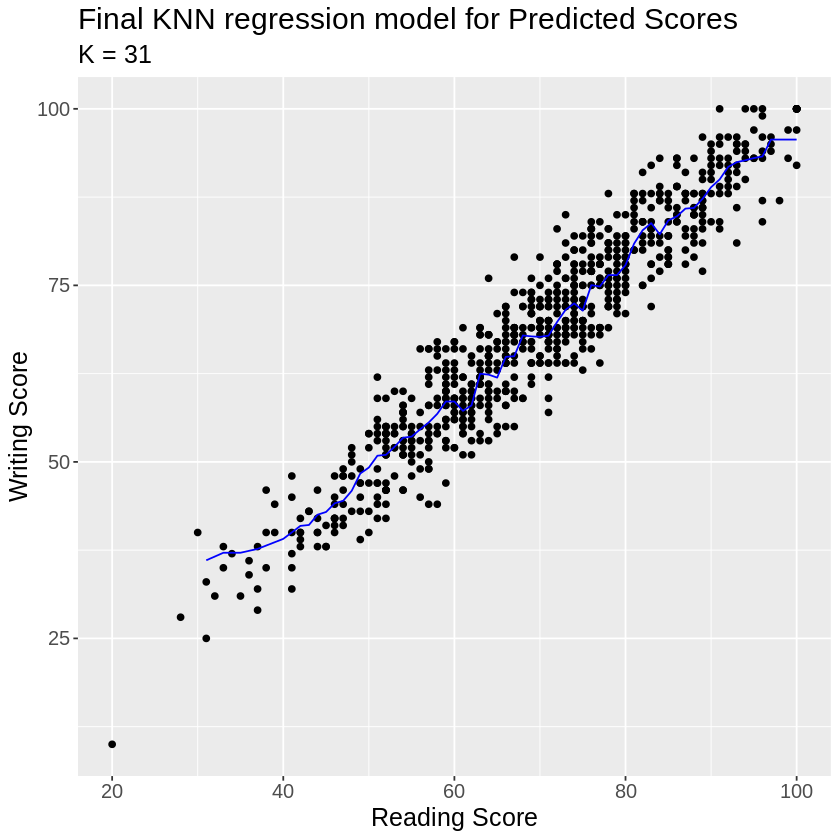

In [21]:
#Scatter plot with Y-predictions line.
predict_plot <- exam_training |>
    ggplot(aes(x = reading_score, y = writing_score)) +
    geom_point() +
    geom_line(data = exam_predict, mapping = aes(x = reading_score, y = .pred), color = "blue") +
    labs(x = "Reading Score", y = "Writing Score") +
    ggtitle("Final KNN regression model for Predicted Scores", paste0("K = ", k_min)) +
    theme(text = element_text(size = 15))
predict_plot

Applying Linear Regression Model Specification:

Since the KNN regression model has limitations where it does not accurately predict beyond the range of the predictors in the training data, we provide an alternative model that is not affected by these limitations, Linear Regression. Similarly to KNN regression,  we begin by building a model specification. However,  we make slight changes to the code where we use the “linear_reg” function, set the engine to  “lm” and set the model to “regression”.

In [22]:
#Linear Regression Model Specification
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

Recipe:

Using the training data set created from the previous model, we fit our variables of interest into a recipe. In our recipe, we do not need to standardize our data.

In [23]:
#Recipe 
lm_recipe <- recipe(writing_score ~ reading_score, data = exam_training)

Creating workflow analysis:

Then, we create a workflow that contains our model specification and recipe as well as to fit in the training dataset. Our fitted simple linear regression model reveals the slope and coefficients for our predictors.

In [24]:
#Creating Workflow and Determining Line of Best Fit
lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = exam_training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
  (Intercept)  reading_score  
       -1.274          1.002  


Assessing the Model:

We evaluate how well our model is by predicting on the testing set.

In [25]:
#Assessing the Model
lm_test_results <- lm_fit |>
  predict(exam_testing) |>
  bind_cols(exam_testing) |>
  metrics(truth = writing_score, estimate = .pred)
lm_test_results
set.seed(2000)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.870370
rsq,standard,0.904954
mae,standard,3.978058


Calculating RMSPE:

After predicting on the test data set, we can extract the RMSPE and return a single numerical value of 4.870. We know from previously,  when the prediction is very close to the true value, the RMSPE value is small, and the opposite is true when the RMSPE value is large. Here, the RMSPE for the simple linear regression model is slightly lower than the RMSPE for the KNN regression model.

In [26]:
#Calculate RMSPE
lm_rmspe <- lm_test_results |>
          filter(.metric == "rmse") |>
          select(.estimate) |>
          pull()
lm_rmspe

[1] 4.87037

Scatter plot with prediction line:

This scatterplot shows the predicted values for our linear regression Model. Thus, we can assess the relationship between a student’s reading score and writing score where the blue line corresponds to the predictions from the fitted model.

`geom_smooth()` using formula = 'y ~ x'


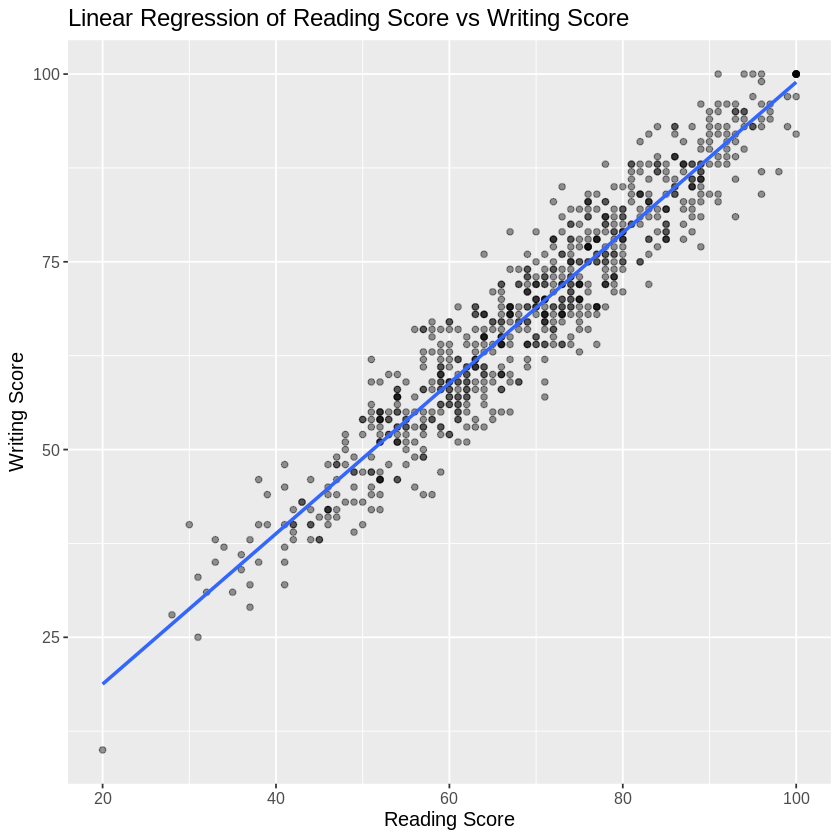

In [27]:
#Scatter plot with Line of Best Fit
lm_plot_final <- ggplot(exam_training, aes(x = reading_score, y = writing_score)) +
  geom_point(alpha = 0.4) +
  xlab("Reading Score") +
  ylab("Writing Score") +
  ggtitle("Linear Regression of Reading Score vs Writing Score")+
  geom_smooth(method = "lm", se = FALSE) + 
  theme(text = element_text(size = 12))
lm_plot_final

Comparison between the Scatterplots between Models:

Having the scatterplots for both regression models side by side allows to visualize both plots and compare the results. In the linear regression model, the line is completely straight while in KNN regression, the line is slightly more influenced by the individual data points so it appears more uneven. The issue with the prediction accuracy for the KNN regression model for reading scores out of the specified range is resolved as the linear model is able to extrapolate the data.


`geom_smooth()` using formula = 'y ~ x'


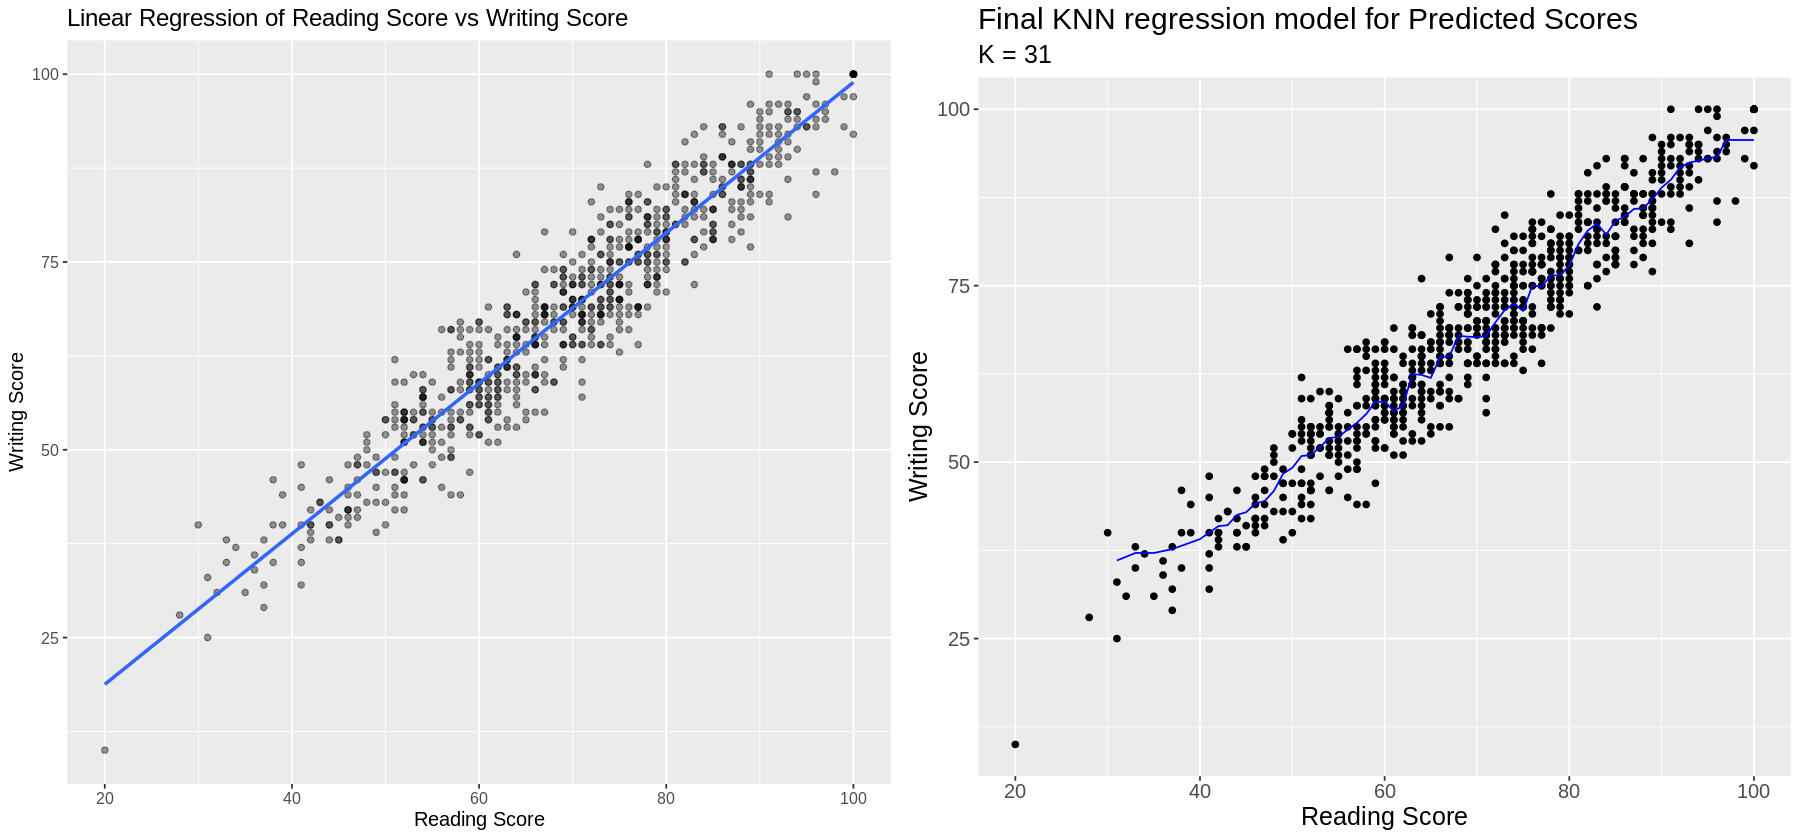

In [28]:
#Comparing Plots of Linear Regression and KNN-Regression Models
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(lm_plot_final, predict_plot, ncol = 2)

<b>Discussion/ Results:</b>
We have found a strong positive correlation between the reading and writing scores of students in the dataset using both the KNN regression and linear regression models. In our predictions, we were able to visualize the relationship between the two variables. This is indicated in both scatterplots, where the blue line that represents the predicted writing scores is generally linear and contains a positive slope. We then further assessed the predictive accuracy of both models by calculating their RMSPE to obtain their expected test errors. For our KNN regression model, we calculated the RMSE (4.955) to indicate how well our model could fit our data. Finding the optimal K value then revealed that our newly-determined RMSPE (4.670) was lower than the RMSE, indicating that the prediction is closer in accuracy. For our simple linear regression model, the determined RMSPE was 4.530. The test error was reduced, making the linear regression model a slightly better predictive model. In observing the low RMSPE, we can confirm our final models as good predictors of our data where the true writing scores are closely correlated with the given reading scores. The correlation between the two scores is as expected due to the similarities of the two subjects. As per the National Council of Teachers of English, “when students receive writing instruction, their reading fluency and comprehension improve”. If we were to look at a student's math score and reading score we might not find them as similar because the subjects are very different, accounted for by the  correlation coefficient in our analysis. However, this could lead to interesting questions such as, if a student does well in one subject, is that due to them being  good at that particular subject or are there other factors that can influence how students perform on exams? Through further research, we can help students to well-roundedly excel in various subjects.

<b>References (APA format):</b>

Timbers, T., Campbell, T., & Lee, M. (2022, September 24). Data Science. Retrieved April 2023, from https://datasciencebook.ca/ 

Fink, L. (2018, October 12). The relationship between writing and reading. National Council of Teachers of English. Retrieved April 11, 2023, from https://ncte.org/blog/2017/12/relationship-writing-reading/ 

Seshapanpu, J. (2018, November 9). Students' performance in exams. Kaggle. Retrieved April 11, 2023, from https://www.kaggle.com/datasets/spscientist/students-performance-in-exams 
